In [2]:
import torch
import sklearn
import pandas as pd
import csv

In [3]:
SpamHam = pd.read_csv('spam_ham_dataset.csv')
SpamHam.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

SpamHam['clean_text'] = SpamHam['text'].apply(clean_text)
SpamHam['clean_text'].head(5)


0    subject enron methanol meter this is a follow ...
1    subject hpl nom for january see attached file ...
2    subject neon retreat ho ho ho we re around to ...
3    subject photoshop windows office cheap main tr...
4    subject re indian springs this deal is to book...
Name: clean_text, dtype: object

In [5]:
def create_vocab(texts):
    vocab = set()
    for text in texts:
        words = text.split()
        vocab.update(words)
    return {word: idx for idx, word in enumerate(sorted(vocab))}

def text_to_bow(text, vocab):
    vector = torch.zeros(len(vocab))
    for word in text.split():
        if word in vocab:
            vector[vocab[word]] += 1
    return vector

vocabulary = create_vocab(SpamHam['clean_text'])
X = torch.stack([text_to_bow(text, vocabulary) for text in SpamHam['clean_text']])
y = torch.tensor(SpamHam['label_num'].values)


In [6]:
class KNearestNeighbors:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        predictions = []
        for x in X:
            distances = torch.norm(self.X_train - x, dim=1)
            _, indices = torch.topk(distances, self.k, largest=False)
            k_nearest_labels = self.y_train[indices]
            values, counts = torch.unique(k_nearest_labels, return_counts=True)
            predictions.append(values[counts.argmax()])
        return torch.tensor(predictions)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNearestNeighbors(k=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test.numpy(), y_pred.numpy())
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test.numpy(), y_pred.numpy()))

Accuracy: 0.8667
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       742
           1       0.73      0.83      0.78       293

    accuracy                           0.87      1035
   macro avg       0.83      0.86      0.84      1035
weighted avg       0.87      0.87      0.87      1035



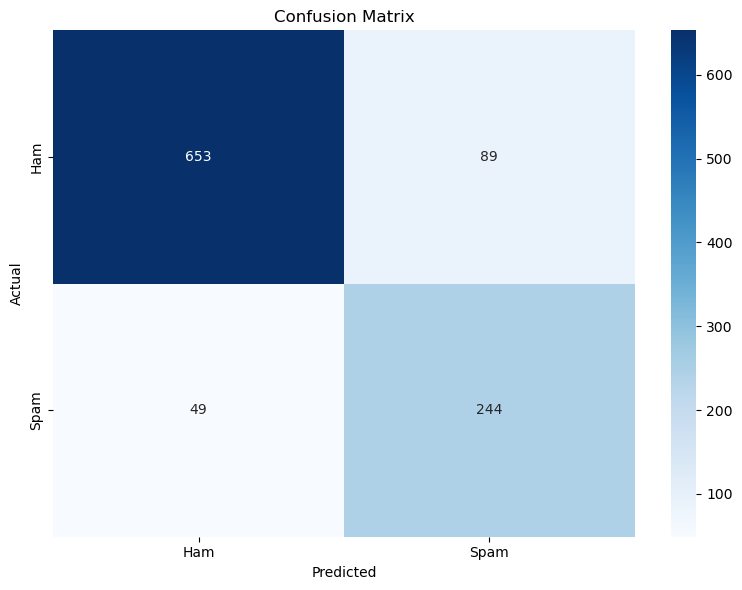

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

cm = confusion_matrix(y_test.numpy(), y_pred.numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()

